## Observing the GP Limit in the FCN3

The goal of this experiment is to show that the GPR limit can be well recovered in a neural network under _standard scaling_ with _low noise_, high _effective data dimension_ and _large enough hidden layers_. What "_large enough_" means is a question of epsilon convergence. 

If GPR is achieved, we expect the model to perform just as well as GPR against the data, and for the discrepancy between the model and the GPR to be "small" compared with the discrepancy of each with respect to the target.  

With `s2=0.01, P=300, N=900,d=2` as our parameters, we see a moderate demonstration that some level of alignment with the GPR is happenning, but no strong order 10 scale difference between the model-GPR discrepancy and the model-target discrepancy. 

These results are encouraging, but not convincing. 

## Defining the Model and Initializing Hyperparameters

In [98]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.init as init

In [99]:

# 2. Generate Data
input_size = 50
hidden_size = 3500
output_size = 1
num_samples = 50
epochs = 2_000_000 # You might increase this with a decaying LR

k = 1.0
t = 2 * k # Temperature for Langevin (currently unused in pure GD, but defined)

# --- Learning Rate Schedule Parameters ---
import math as mt
T = 800_000
lrA = 1e-8 / num_samples
lrB = (1.0 / 3) * lrA / num_samples 
beta =  mt.log(lrA / lrB) / T

print(lrA * mt.exp(-beta * 1000))

# ------------------------------------------
# Set the default dtype to float64
torch.set_default_dtype(torch.float64)

device = torch.device("cuda:1")

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"Default PyTorch dtype: {torch.get_default_dtype()}")

# 1. Define the Two-Layer Linear Neural Network
class ThreeLayerLinearNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ThreeLayerLinearNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size, bias=False, dtype=torch.float64)
        self.fc2 = nn.Linear(hidden_size, hidden_size, bias=False, dtype=torch.float64)
        self.fc3 = nn.Linear(hidden_size, output_size, bias=False, dtype=torch.float64)
        
        # Use 1/sqrt(fan_in) initialization (as recommended)
        init.normal_(self.fc1.weight, mean=0.0, std=1/np.sqrt(input_size))
        init.normal_(self.fc2.weight, mean=0.0, std=1/np.sqrt(hidden_size))
        init.normal_(self.fc3.weight, mean=0.0, std=1/np.sqrt(hidden_size))

    def forward(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

class ThreeLayerLinearNetEnsemble(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, ens = 1):
        super(ThreeLayerLinearNetEnsemble, self).__init__()
        weight_initialization_variance = (1.0/input_size, 1.0/hidden_size, 1.0/hidden_size)
        self.arch = [input_size, hidden_size, output_size]
        self.d = input_size
        self.n1 = hidden_size
        self.n2 = output_size
        self.W0 = nn.Parameter(torch.normal(mean=0.0,
                                            std=torch.full((ens, hidden_size, input_size), weight_initialization_variance[0]**0.5)).to(device),
                                            requires_grad=True) # requires_grad moved here
        self.W1 = nn.Parameter(torch.normal(mean=0.0,
                                            std=torch.full((ens, output_size, hidden_size), weight_initialization_variance[1]**0.5)).to(device),
                                            requires_grad=True).to(device) # requires_grad moved here
        self.A = nn.Parameter(torch.normal(mean=0.0,
                                           std=torch.full((ens, 1, output_size), weight_initialization_variance[2]**0.5)).to(device),
                                           requires_grad=True).to(device) # requires_grad moved here


    def h1_activation(self, X):
        return contract(
            'ijk,ikl,unl->uij',
            self.W1, self.W0, X,
            backend='torch'
        )

    def h0_activation(self, X):
        return contract(
            'ikl,unl->uik',
            self.W0, X,
            backend='torch'
        )


    def forward(self, X):
        """

        Efficiently computes the outputs of a three layer network
        using opt_einsum

        f : P*d -> P*e*1
        C1_ui = W1_ijk*x_uk
        C2_uij = W2_ijk*C1_uik
        C3_ui = A_ij*C2_uij
        """
        A = self.A
        W1 = self.W1
        W0 = self.W0

        return contract(
            'eij,ejk,ekl,ul->uie',
            A, W1, W0, X,
          backend='torch'
        )


1.9875125588454294e-10
Using device: cuda:1
Default PyTorch dtype: torch.float64


In [100]:

# Set seeds as constants
DATA_SEED = 613
MODEL_SEED = 26
LANGEVIN_SEED = 480

# Seed for data
torch.manual_seed(DATA_SEED)
X = torch.randn((num_samples, input_size), dtype=torch.float64).to(device)
Y = X[:,0].unsqueeze(-1).to(device)

# Seed for model
torch.manual_seed(MODEL_SEED)
model = ThreeLayerLinearNet(input_size, hidden_size, output_size).to(device)

# Seed for Langevin noise
torch.manual_seed(LANGEVIN_SEED)

In [101]:

model = model.to(device)
X = X.to(device)
Y = Y.to(device)

In [102]:
import gc
gc.collect()

1072

In [103]:
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")
    for i in range(num_gpus):
        device_name = torch.cuda.get_device_name(i)
        print(f"GPU {i}: {device_name}")
else:
    print("CUDA is not available. No GPUs found.")

Number of GPUs available: 2
GPU 0: NVIDIA GeForce RTX 4090
GPU 1: NVIDIA GeForce RTX 4080


In [104]:
import tqdm

## Running Training

We see "good" loss convergence, with loss on the order of `~1e-5`, which is indicative that convergence is happening, though we must still find better hyperparameters if we want excellent convergence


In [105]:
from tqdm import tqdm
print(tqdm)

<class 'tqdm.std.tqdm'>


In [ ]:
from opt_einsum import contract
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Placeholder for weight decay (assuming it's still disabled for pure GD)
weight_decay = np.array([input_size, hidden_size, hidden_size], dtype=np.float64) * t

criterion = nn.MSELoss(reduction='sum')
epoch = 0
losses = []
# Create tqdm progress bar
progress_bar = tqdm(total=epochs, desc="Training", position=0)

while epoch < epochs:
    if epoch < epochs * 0.8:
        current_base_learning_rate = lrA

    elif epoch > epochs * 0.8:
        current_base_learning_rate = lrA / 3
    
    # Calculate the effective learning rate for the update step
    effective_learning_rate_for_update = current_base_learning_rate 

    noise_scale = (2 * effective_learning_rate_for_update * t)**0.5
    # Forward pass
    outputs = model(X)
    loss = criterion(outputs, Y)
    losses.append(loss.item())

    # Backward pass
    model.zero_grad()
    loss.backward()

    # Manually update weights (Pure Gradient Descent)
    param_index = 0
    with torch.no_grad():
        for name, param in model.named_parameters():
            if param.grad is not None:
                # Gradient term
                param.data.add_(-effective_learning_rate_for_update * param.grad.data)
                
                # Keep these commented out for pure GD
                noise = torch.randn_like(param.data) * noise_scale 
                param.data.add_(noise)
                param.data.add_(-param.data * weight_decay[param_index] * effective_learning_rate_for_update)
                
            param_index += 1 

    # Update tqdm progress bar with current loss and learning rate

    progress_bar.set_postfix({
        'MSE Loss': f'{loss.item() / num_samples:.12f}',
        'Lr': f'{current_base_learning_rate:.10f}'
    })
    
    if (epoch + 1) % 10000 == 0 or epoch == 0: 
        
        modeldesc = f"model_epochs{epochs}_N_{hidden_size}_D_{input_size}_P_{num_samples}"
        # Construct a filename that includes key parameters
        model_filename = modeldesc
        # Optionally, replace problematic characters for filenames
        model_filename = model_filename.replace('.', 'p')

        # Save the model state_dict
        torch.save(model.state_dict(), model_filename)
        with open(f"losses_{modeldesc}.txt", "a") as f: 
            f.write(str(epoch) + ',' + str(loss.item()) + '\n')
    
    epoch += 1
    progress_bar.update(1)

# Close the progress bar
progress_bar.close()

# Optional: Plotting the loss
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss (sum)')
plt.title('Training Loss over Epochs (Float64 with LR Schedule)')
plt.grid(True)
plt.yscale('log')
plt.show()

Training:   2%|█                                                     | 40443/2000000 [16:15<13:15:43, 41.04it/s, MSE Loss=2.850651454564, Lr=0.0000000002]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Training:  12%|██████                                             | 237765/2000000 [4:27:00<74:02:57,  6.61it/s, MSE Loss=0.750639505271, Lr=0.0000000002]

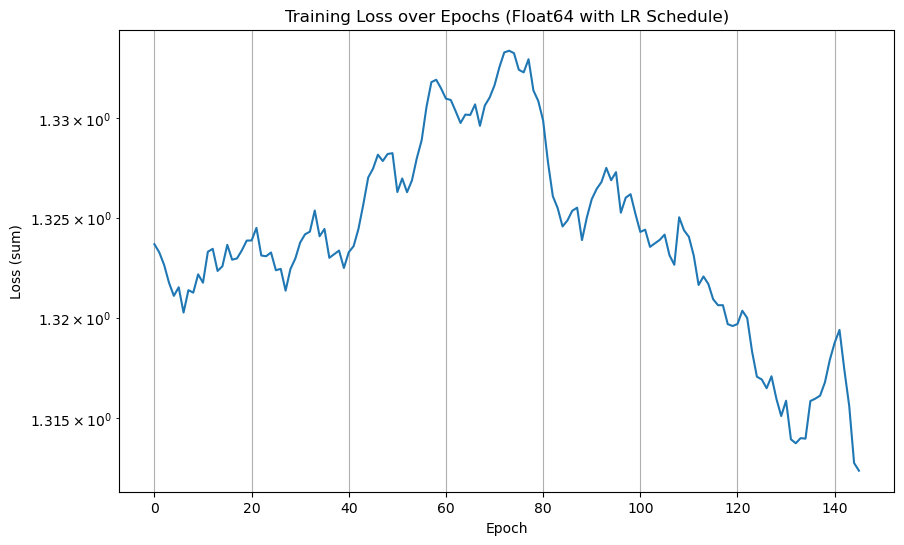

Training:   0%|                                                            | 145/2000000 [00:23<25:43:14, 21.60it/s, MSE Loss=2.625564374572, Lr=0.000000]

In [87]:
# Optional: Plotting the loss
plt.figure(figsize=(10, 6))
plt.plot(np.array(losses)/100)
plt.xlabel('Epoch')
plt.ylabel('Loss (sum)')
plt.title('Training Loss over Epochs (Float64 with LR Schedule)')
plt.grid(True)
plt.yscale('log')
plt.show()

In [68]:
if epoch < 2_000_000 * 0.8:
    print("LOW TIMESFCALE")
elif epoch >  2_000_000 * 0.8:
    print("High Timescale")

LOW TIMESFCALE


In [69]:
current_base_learning_rate = lrA
modeldesc = f"model_epochs{epochs}_lr{current_base_learning_rate}_N_{hidden_size}_D_{input_size}_P_{num_samples}"

# Construct a filename that includes key parameters
model_filename = (
   modeldesc        
)
model_filename

'model_epochs2000000_lr2e-10_N_5000_D_50_P_50'

In [70]:
losses = []
epoch_nums = []

with open(f"/home/akiva/FCNX-Ensembling/scripts/losses_model_epochs100000000_N_3000_D_50_P_50.txt", "r") as f:
    for line in f:
        line = line.strip()
        if line:  # Ensure the line is not empty
            parts = line.split(',')
            if len(parts) == 2:
                try:
                    epoch = int(parts[0].strip())
                    loss = float(parts[1].strip())
                    epoch_nums.append(epoch)
                    losses.append(loss)
                except ValueError:
                    print(f"Skipping malformed line: {line}")
            else:
                print(f"Skipping line with incorrect format: {line}")

# If you have an existing 'loss' list you want to append to the end of the new 'losses' list:
# losses.extend(existing_loss_list) # Use .extend() to add elements from another list

In [71]:
losses

[184.36163013006376,
 144.4562467497563,
 131.2465945933879,
 117.98300060638121,
 104.88187000360654,
 98.08265078390902,
 87.0578371922837,
 78.78780913903073,
 76.18271908442219,
 69.4037176503766,
 60.3922930161613,
 53.55386070466369,
 51.85823969734851,
 45.77917301553133,
 45.43669270052571,
 40.471398943971295,
 39.15693044769055,
 36.99542714758272,
 39.562821067710345,
 38.6467652068219,
 41.52280240180932,
 44.237274329003355,
 41.78241258687996,
 41.33215223105124,
 41.594882293655914,
 40.547684110871785,
 39.087002952650906,
 41.18617679793144,
 47.400875356338695,
 43.926435531079576,
 46.80126902340209,
 44.424194274621634,
 44.397322365054315]

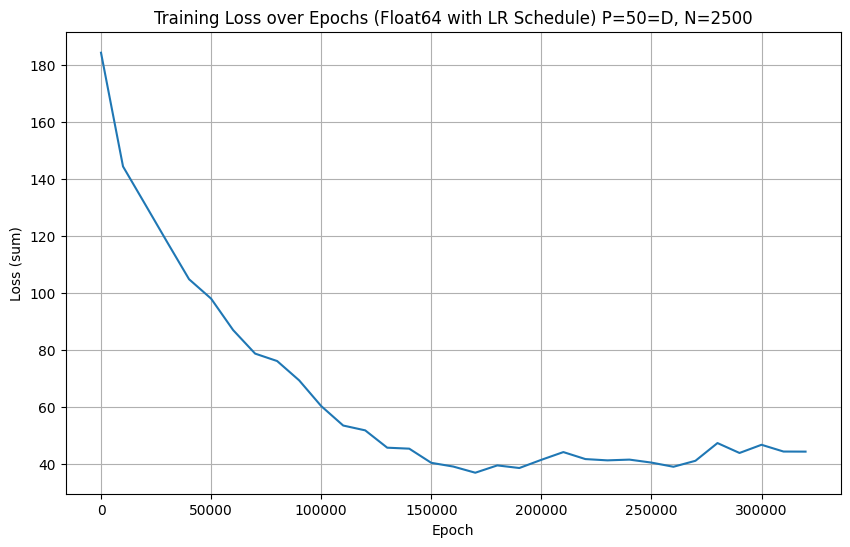

In [95]:
if len(epoch_nums) < len(losses):
    epoch_nums = range(len(losses))
# Optional: Plotting the loss
plt.figure(figsize=(10, 6))
plt.plot(epoch_nums, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss (sum)')
plt.title('Training Loss over Epochs (Float64 with LR Schedule) P=50=D, N=2500')
plt.grid(True)
# plt.yscale('log')
plt.show()

In [13]:
import os

# Construct a filename that includes key parameters
model_filename = (
    f"VERY MANY EPOCHS SMALL LR model_epochs{epochs}_lr{lrA: 0.4f}_N_{hidden_size}_D_{input_size}_P_{num_samples}"
)

# Optionally, replace problematic characters for filenames
model_filename = model_filename.replace('.', 'p')

# Save the model state_dict
torch.save(model.state_dict(), model_filename)
print(f"Model saved to {model_filename}")



Model saved to VERY MANY EPOCHS SMALL LR model_epochs100000000_lr 0p0000_N_2500_D_50_P_50


In [32]:
# Load the specified model state_dict using torch.load and load_state_dict
load_model_filename = "model_epochs1000000_lr0p001_decay0p5_decayepochs50000_t0p02_wd0p04-18p0-18p0ppt"
load_model_filename2 = "VERY MANY EPOCHS SMALL LR model_epochs100000000_lr 0p0000_N_2500_D_50_P_50"
model.load_state_dict(torch.load(load_model_filename2))
print(f"Loaded model state_dict from {load_model_filename2}")
model = model.to(device)



Loaded model state_dict from VERY MANY EPOCHS SMALL LR model_epochs100000000_lr 0p0000_N_2500_D_50_P_50


/tmp/ipykernel_822492/4198467369.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(load_model_filename2))


NameError: name 'true_gpr_np' is not defined

## Model Performance

I want to make sure the scale of the outputs aligns with the scale of the target, just as a test that my weight scaling is correct. 

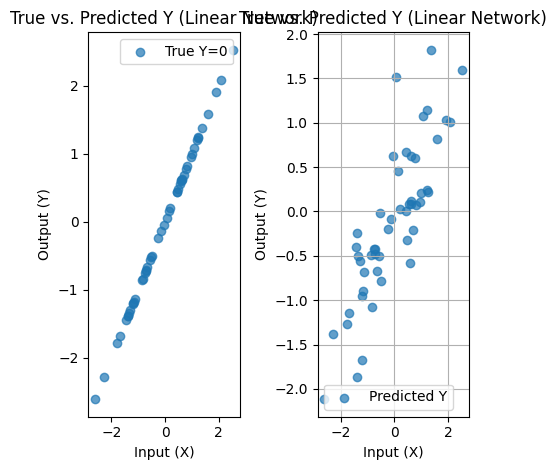

In [74]:
# 4. Visualize Results
model.eval() # Set model to evaluation mode
with torch.no_grad():
    predicted_Y = model(X).cpu().numpy()

# plt.figure(figsize=(10, 5))
# plt.subplot(1, 3, 1)
# plt.plot(losses)
# plt.title('Loss over Epochs (Linear Network)')
# plt.xlabel('Epoch')
# plt.ylabel('MSE Loss')

plt.subplot(1, 3, 2)
plt.scatter(X[:,0].cpu().numpy(), Y.cpu().numpy(), label='True Y=0', alpha=0.7)
plt.title('True vs. Predicted Y (Linear Network)')
plt.xlabel('Input (X)')
plt.ylabel('Output (Y)')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(X[:,0].cpu().numpy(), predicted_Y, label='Predicted Y', alpha=0.7)
plt.title('True vs. Predicted Y (Linear Network)')
plt.xlabel('Input (X)')
plt.ylabel('Output (Y)')
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

# print("\nModel learned parameters (Linear Network with Langevin Dynamics):")
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(f"{name}: {param.data.numpy()}")

In [75]:
X

tensor([[ 0.7701,  0.0459,  1.1291,  ...,  1.2159,  0.5087, -0.3950],
        [ 0.1511,  0.4723, -1.0165,  ..., -0.4662,  1.9744, -0.5457],
        [ 1.2059,  2.7352, -1.9625,  ..., -1.5851,  2.2925,  0.0088],
        ...,
        [ 1.0816,  0.4099,  0.9432,  ...,  1.1328,  0.8769,  0.7551],
        [ 1.9107,  1.4296, -0.1155,  ...,  0.3874,  1.5821, -0.2403],
        [ 1.5867,  0.6689, -0.1317,  ..., -0.7946,  0.1982,  0.3055]],
       device='cuda:1')

In [ ]:
import sys
sys.path.append('/home/akiva/FCNX-Ensembling/')

from GPKit import *
true_gpr = gpr_dot_product_explicit(X, Y, X, 1.0).cpu().detach()
prediction = model(X).cpu().detach()
tru_y =  Y.cpu()

# Move all data to CPU numpy arrays
tru_y_np = tru_y.numpy() if hasattr(tru_y, 'cpu') else tru_y
true_gpr_np = true_gpr.cpu().numpy() if hasattr(true_gpr, 'cpu') else true_gpr
prediction_np = prediction.cpu().numpy() if hasattr(prediction, 'cpu') else prediction
X_np = X.cpu().numpy() if hasattr(X, 'cpu') else X

# Print shapes of all these arrays/tensors
print("tru_y_np shape:", getattr(tru_y_np, "shape", "no shape"))
print("true_gpr_np shape:", getattr(true_gpr_np, "shape", "no shape"))
print("prediction_np_cpu shape:", getattr(prediction_np, "shape", "no shape"))
print("X_np shape:", getattr(X_np, "shape", "no shape"))



def cosine_similarity(a, b):
    """
    Compute the cosine similarity between two numpy arrays.
    """
    a_flat = a.ravel()
    b_flat = b.ravel()
    numerator = np.dot(a_flat, b_flat)
    denominator = np.linalg.norm(a_flat) * np.linalg.norm(b_flat)
    cossim = numerator / denominator if denominator != 0 else np.nan
    return np.arccos(cossim) * 180 / np.pi 

def me(a,b):
    return np.mean((a - b))  / num_samples

# Compute cosine similarity between true_gpr_np and prediction_np

mse_nn_gpr = me(true_gpr_np, prediction_np) 
print("MSE similarity between true_gpr_np and prediction_np:", mse_nn_gpr)

# Compute cosine similarity between true_gpr_np and tru_y
mse_nn_truy = me(prediction_np, tru_y_np) 
print("MSE similarity between prediction_np and tru_y_np:", mse_nn_truy)

# Compute cosine similarity between true_gpr_np and tru_y
mse_gpr_truy = me(true_gpr_np, tru_y_np) 
print("MSE similarity between true_gpr_np and tru_y:", mse_gpr_truy)
import matplotlib.pyplot as plt
import numpy as np

# Ensure prediction is a numpy array for plotting
if hasattr(prediction, "detach"):
    prediction_np = prediction.detach().cpu().numpy()
else:
    prediction_np = np.array(prediction)

# Flatten arrays if needed for scatter plot
gpr_flat = true_gpr.flatten()
pred_flat = prediction_np.flatten()

plt.figure(figsize=(7, 7))
plt.scatter(gpr_flat, pred_flat, alpha=0.7, label='Model Prediction vs. GPR')
min_val = min(gpr_flat.min(), pred_flat.min())
max_val = max(gpr_flat.max(), pred_flat.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='$y=x$')
plt.xlabel('GPR Prediction (true_gpr)')
plt.ylabel('Model Prediction')
plt.title('Scatter Plot: Model Prediction vs. GPR Prediction')
plt.legend()
plt.axis('equal')  # Keep x and y axis with the same scale
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
slope = lambda x, y: np.polyfit(x, y, 1)[0].item() if len(x) == len(y) else None
import matplotlib.pyplot as plt
import numpy as np

# Ensure prediction is a numpy array for plotting
if hasattr(prediction, "detach"):
    prediction_np = prediction.detach().cpu().numpy()
else:
    prediction_np = np.array(prediction)

# Use x[:,0] as the x-axis for plotting
if hasattr(X, "detach"):
    x_plot = X.detach().cpu().numpy()
else:
    x_plot = np.array(X)
x_axis = x_plot[:,0] if x_plot.ndim > 1 else x_plot

# Plot comparison of true_gpr, prediction, and tru_y
plt.figure(figsize=(10, 6))
s1 = slope(x_axis, true_gpr)
s2 = slope(x_axis, prediction_np[:, 0] if prediction_np.ndim > 1 else prediction_np)
s3 = slope(x_axis, tru_y[:, 0] if tru_y.ndim > 1 else tru_y)
plt.scatter(x_axis, true_gpr, label=f'GPR Prediction (true_gpr), m={s1:.4f}', marker='o')
plt.scatter(x_axis, prediction_np[:, 0] if prediction_np.ndim > 1 else prediction_np, label=f'Model Prediction, m={s2:.4f}', marker='x')
plt.scatter(x_axis, tru_y[:, 0] if tru_y.ndim > 1 else tru_y, label=f'True $y$ (tru_y), m={s3:.4f}', marker='s')


plt.xlabel('Input $x$')
plt.ylabel('Output Value')
plt.title('Comparison: GPR vs. Model Prediction vs. True $y$')
plt.legend()
plt.grid(True)
plt.tight_layout()
# Plot each curve in a separate figure, one beneath the other

# Plot 1: GPR Prediction (true_gpr)
plt.figure(figsize=(10, 6))
plt.scatter(x_axis, true_gpr, label='GPR Prediction (true_gpr)', marker='o')
plt.xlabel('Input $x$')
plt.ylabel('Output Value')
plt.title('GPR Prediction (true_gpr)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Model Prediction
plt.figure(figsize=(10, 6))
plt.scatter(x_axis, prediction_np[:,0] if prediction_np.ndim > 1 else prediction_np, label='Model Prediction', marker='x')
plt.xlabel('Input $x$')
plt.ylabel('Output Value')
plt.title('Model Prediction')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3: True y (tru_y)



plt.figure(figsize=(10, 6))
plt.scatter(x_axis, tru_y[:,0] if tru_y.ndim > 1 else tru_y, label='True $y$ (tru_y)', marker='s')
plt.xlabel('Input $x$')
plt.ylabel('Output Value')
plt.title('True $y$ (tru_y)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


tru_y_np shape: (300, 1)
true_gpr_np shape: (300, 1)
prediction_np_cpu shape: (300, 1)
X_np shape: (300, 2)


I want to see the residuals of the GPR-Target versus the Model-Target. By computing the cosine similarity we can see that the GPR and the predictor are more closely aligned than the predictor is with the target. 

In [60]:
def cosine_similarity(a, b):
    """
    Compute the cosine similarity between two numpy arrays.
    """
    a_flat = a.ravel()
    b_flat = b.ravel()
    numerator = np.dot(a_flat, b_flat)
    denominator = np.linalg.norm(a_flat) * np.linalg.norm(b_flat)
    cossim = numerator / denominator if denominator != 0 else np.nan
    return np.arccos(cossim) * 180 / np.pi 


In [61]:
# Compute cosine similarity between true_gpr_np and prediction_np

cos_sim_nn_gpr = cosine_similarity(true_gpr_np, prediction_np) 
print("Cosine similarity between true_gpr_np and prediction_np:", cos_sim_nn_gpr)

# Compute cosine similarity between true_gpr_np and tru_y
cos_sim_nn_truy = cosine_similarity(prediction_np, tru_y_np) 
print("Cosine similarity between prediction_np and tru_y_np:", cos_sim_nn_truy)

# Compute cosine similarity between true_gpr_np and tru_y
cos_sim_gpr_truy = cosine_similarity(true_gpr_np, tru_y_np) 
print("Cosine similarity between true_gpr_np and tru_y:", cos_sim_gpr_truy)

Cosine similarity between true_gpr_np and prediction_np: 30.9211446404372
Cosine similarity between prediction_np and tru_y_np: 33.22997793548971
Cosine similarity between true_gpr_np and tru_y: 11.263760900137784


In [62]:

# Compute residuals
gpr_residuals = tru_y_np - true_gpr_np
model_residuals = prediction_np - tru_y_np

# Print shapes of the residuals
print("gpr_residuals shape:", getattr(gpr_residuals, "shape", "no shape"))
print("model_residuals shape:", getattr(model_residuals, "shape", "no shape"))


gpr_residuals shape: (50, 1)
model_residuals shape: (50, 1)


In [63]:
# Compute cosine similarity between gpr_residuals and model_residuals using numpy
numerator = np.dot(gpr_residuals.ravel(), model_residuals.ravel())
denominator = np.linalg.norm(gpr_residuals.ravel()) * np.linalg.norm(model_residuals.ravel())
cosine_similarity = numerator / denominator if denominator != 0 else np.nan
print("Cosine similarity between residuals:", cosine_similarity)

Cosine similarity between residuals: -0.7236307356883473


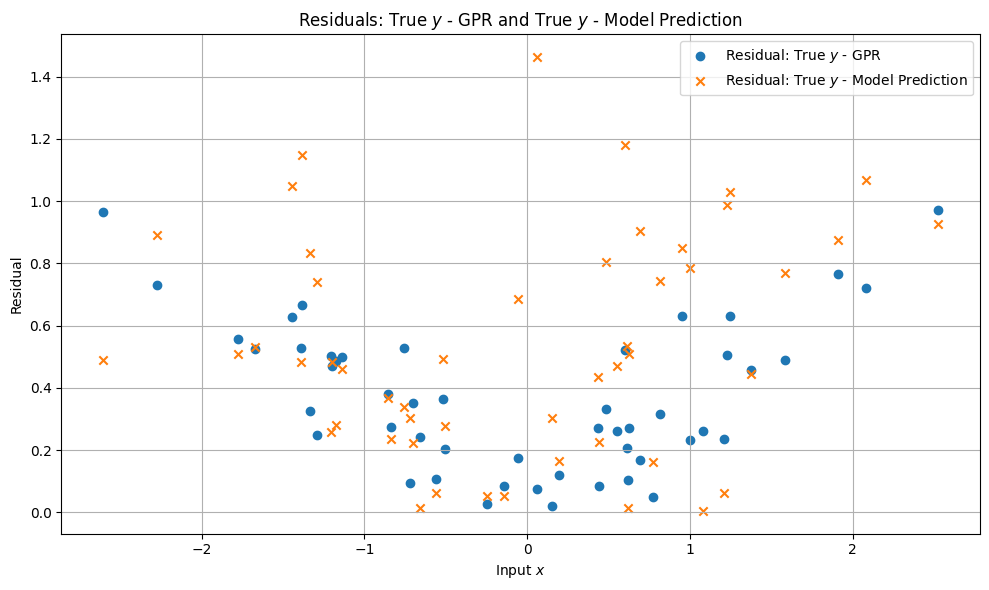

In [64]:
# Plot residuals: (true_y - GPR) and (true_y - Model Prediction) vs x[:,0]
plt.figure(figsize=(10, 6))
x_plot = X_np[:,0] if X_np.ndim > 1 else X_np

plt.scatter(x_plot, np.abs(gpr_residuals), label='Residual: True $y$ - GPR', marker='o')
plt.scatter(x_plot, np.abs(model_residuals), label='Residual: True $y$ - Model Prediction', marker='x')

plt.xlabel('Input $x$')
plt.ylabel('Residual')
plt.title('Residuals: True $y$ - GPR and True $y$ - Model Prediction')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


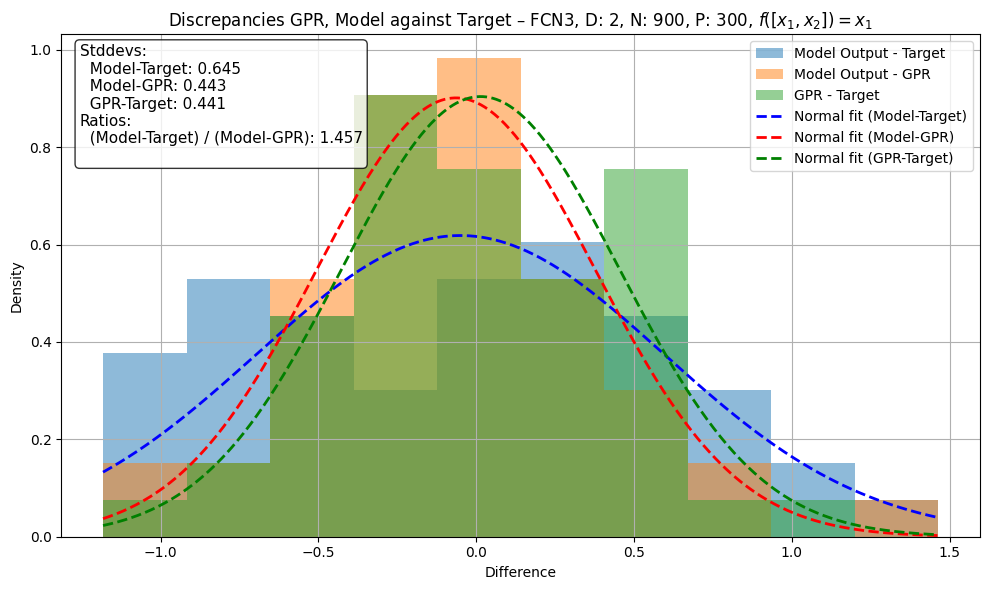

In [66]:
# Plot histogram of differences: |model output - target| vs |model output - GPR| vs |GPR - target|, overlay Gaussians, show stddev ratios as a note on the plot

model_output = prediction_np if 'model_pred_np' in locals() else prediction_np  # fallback if variable name differs
target = tru_y_np if 'true_y_np' in locals() else tru_y_np  # fallback if variable name differs
gpr = true_gpr_np if 'gpr_pred_np' in locals() else true_gpr_np  # fallback if variable name differs

# If not already numpy arrays, convert
if not isinstance(model_output, np.ndarray):
    model_output = np.array(model_output)
if not isinstance(target, np.ndarray):
    target = np.array(target)
if not isinstance(gpr, np.ndarray):
    gpr = np.array(gpr)

diff_model_target = model_output - target
diff_model_gpr = model_output - gpr
diff_gpr_target = gpr - target

# Compute means and stddevs
mean_model_target = np.mean(diff_model_target)
std_model_target = np.std(diff_model_target)
mean_model_gpr = np.mean(diff_model_gpr)
std_model_gpr = np.std(diff_model_gpr)
mean_gpr_target = np.mean(diff_gpr_target)
std_gpr_target = np.std(diff_gpr_target)

# Compute stddev ratios
std_ratio_model_gpr =  std_model_target / std_model_gpr  if std_model_gpr != 0 else np.nan

# Choose bins to cover all distributions
all_diffs = np.concatenate([diff_model_target, diff_model_gpr, diff_gpr_target])
num_bins = 10
bins = np.linspace(np.min(all_diffs), np.max(all_diffs), num_bins + 1)

plt.figure(figsize=(10, 6))
# Plot histograms
plt.hist(diff_model_target, bins=bins, alpha=0.5, label='Model Output - Target', density=True)
plt.hist(diff_model_gpr, bins=bins, alpha=0.5, label='Model Output - GPR', density=True)
plt.hist(diff_gpr_target, bins=bins, alpha=0.5, label='GPR - Target', density=True)

# Overlay Gaussian curves
x = np.linspace(np.min(all_diffs), np.max(all_diffs), 500)
from scipy.stats import norm
plt.plot(x, norm.pdf(x, mean_model_target, std_model_target), 'b--', lw=2, label='Normal fit (Model-Target)')
plt.plot(x, norm.pdf(x, mean_model_gpr, std_model_gpr), 'r--', lw=2, label='Normal fit (Model-GPR)')
plt.plot(x, norm.pdf(x, mean_gpr_target, std_gpr_target), 'g--', lw=2, label='Normal fit (GPR-Target)')

plt.xlabel('Difference')
plt.ylabel('Density')
plt.title('Discrepancies GPR, Model against Target – FCN3, D: 2, N: 900, P: 300, $f([x_1, x_2]) = x_1$')

# Add stddev info as a note on the top left of the plot
stddev_note = (
    f'Stddevs:\n'
    f'  Model-Target: {std_model_target:.3f}\n'
    f'  Model-GPR: {std_model_gpr:.3f}\n'
    f'  GPR-Target: {std_gpr_target:.3f}\n'
    f'Ratios:\n'
    f'  (Model-Target) / (Model-GPR): {std_ratio_model_gpr:.3f}\n'
)
plt.gca().text(
    0.02, 0.98, stddev_note,
    transform=plt.gca().transAxes,
    fontsize=11,
    verticalalignment='top',
    horizontalalignment='left',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Am I satisfied with this? Not really, because the order of magnitude of the convergence to the GPR is not too good. What I really want to see is the orange curve become quite sharp and the blue and green curves start to align with very small error. 

To see where to go, I need to test the asymptotic properties. I am sure that kappa needs to be kept quite small and that the learning rate needs to be made quite small as well. There must also be a substantial number of datapoints, and N must be even larger than that if we would really like to get _low loss_ and _convergence to the GPR_ – which seems to be a lot harder than simply naively training a smaller network. 

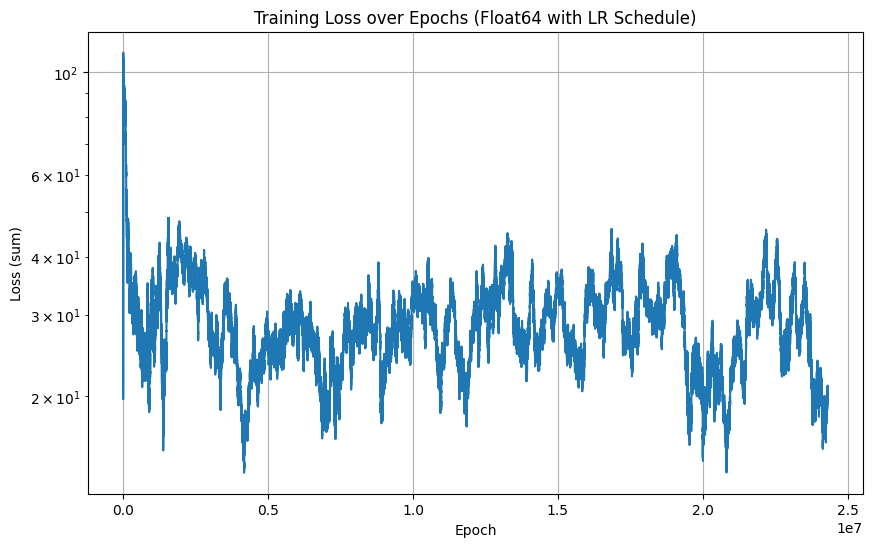

In [67]:
# Optional: Plotting the loss
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss (sum)')
plt.title('Training Loss over Epochs (Float64 with LR Schedule)')
plt.grid(True)
plt.yscale('log')
plt.show()